In [95]:
from generate_samples_laplace import SyntheticDAG
from causal_peeler_t import *
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns


In [96]:
plt.rcParams.update({'font.size': 15})

In [97]:
def sample_full_rank_matrix(n=3, lower=-10, upper=10):
    while True:
        matrix = torch.FloatTensor(n, n).uniform_(lower, upper)
        matrix.requires_grad_(True)
        matrix.retain_grad()
        if torch.det(matrix).item() != 0:
            return matrix


In [98]:
def noise_estimation(id_layers, layers):
    noise_estimates = np.zeros_like(id_layers)
    noise_estimates[:,0] = id_layers[:,0]
    upstream=[0]
    for layer in layers[1:]:
        for i in layer:
            degree = 2  # Degree of the polynomial features
            poly_features = PolynomialFeatures(degree=degree)
            X_poly = poly_features.fit_transform(id_layers[:,upstream])
            model = LinearRegression()
            model.fit(X_poly, id_layers[:,i])
            noise_estimates[:,i] = id_layers[:,i] - model.predict(X_poly)
        upstream+=layer
    return noise_estimates

In [99]:
layers = [[0], [1], [2], [3]]
DAG_type = 'line'
num_latent = 4
num_samples = 3000
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)

In [100]:
graph = SyntheticDAG(num_latent, DAG_type)

In [101]:
U,X,noises = graph.sample_scaled(G, num_samples)

In [102]:
id_layers = identify(graph, U, X, G, 0)

-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Optimal solution found:
[-0.28857377 -0.17535733 -0.77641751  0.53211919]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[ 1.98326960e+00  4.30006763e-01 -2.15674688e+00  7.26194588e-01]
 [-1.21886092e+00 -3.29892550e-01  2.85550867e+00 -9.72740062e-04]
 [-1.37473741e+00 -6.81134831e-01  1.65610870e+00 -2.36112736e-04]
 [ 4.08825462e+00  1.81539338e+00 -2.79936297e+00 -3.72807334e-04]]

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Optimal solution found:
[-0.62292812 -0.37704253  0.68541921]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[ 4.18471478  1.70343

In [103]:
noise_estimates = noise_estimation(id_layers, layers)

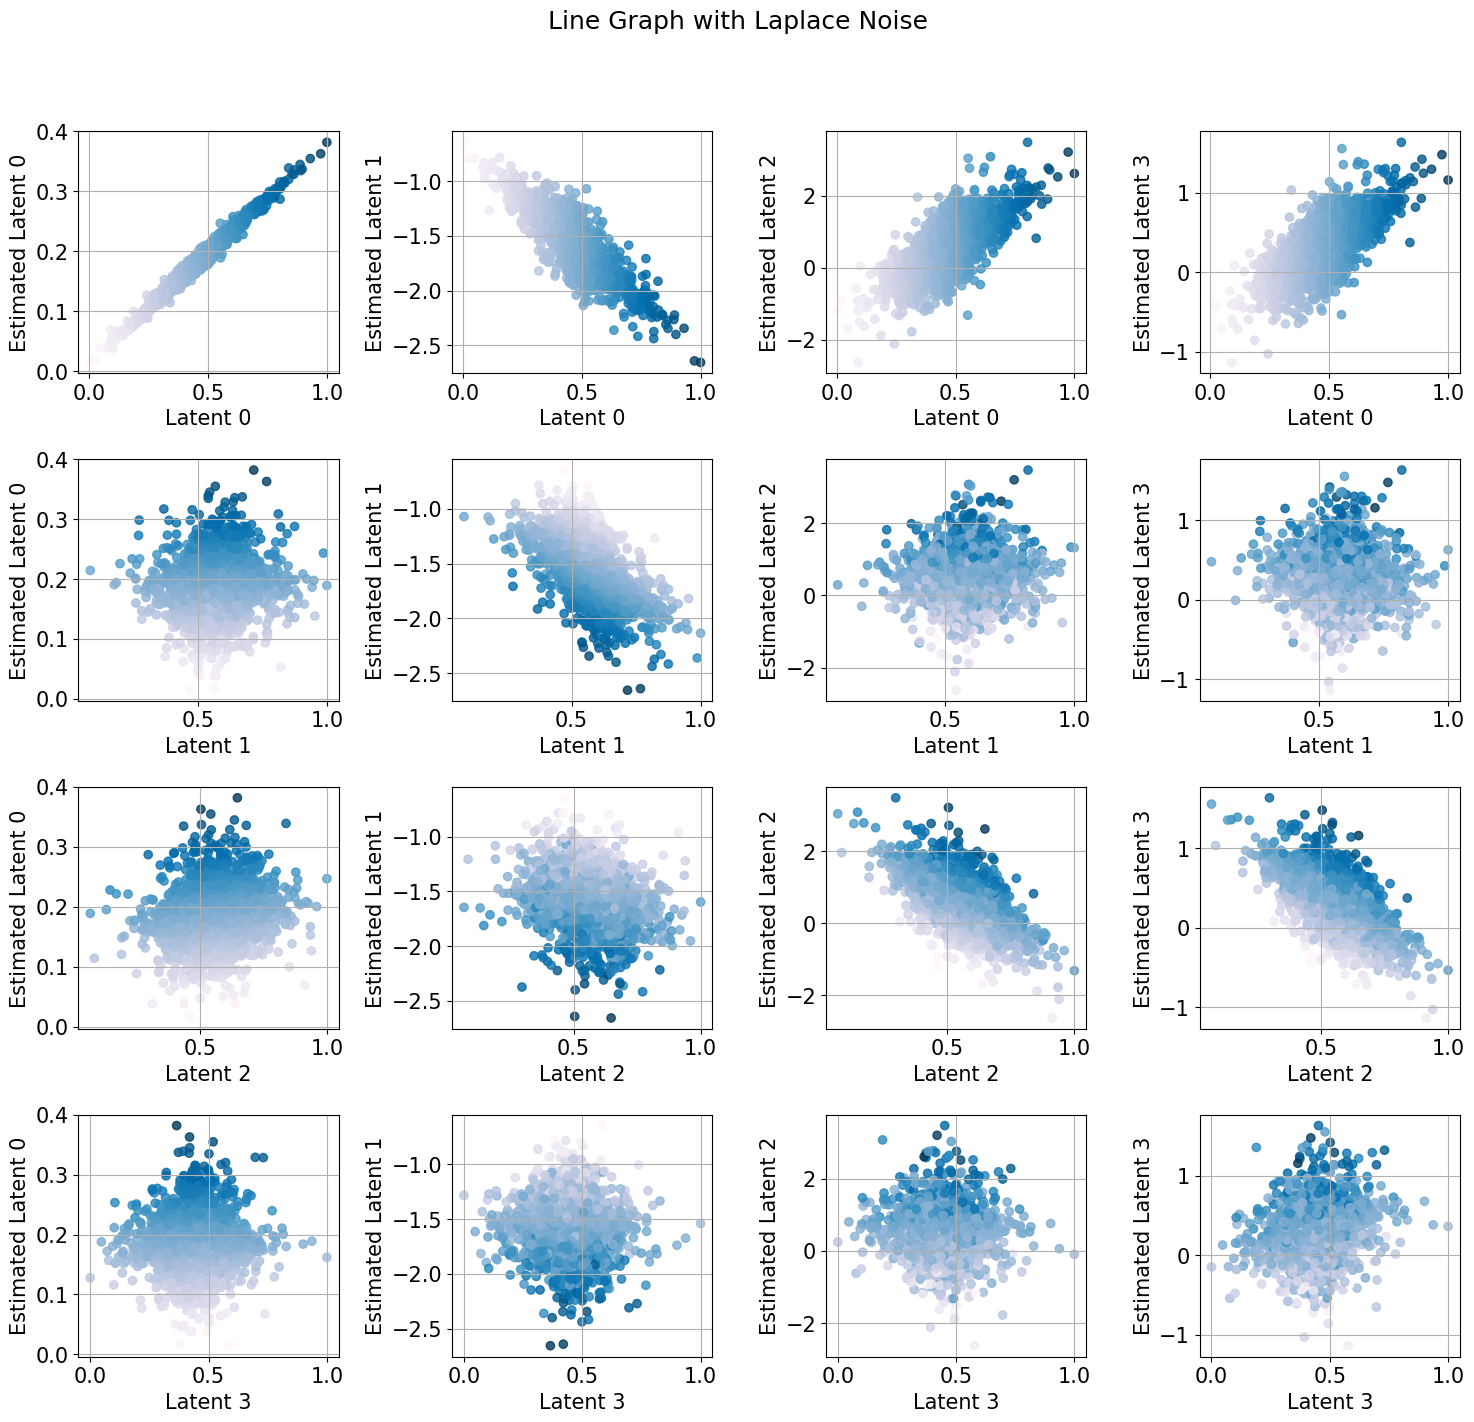

In [104]:
U_np = U.detach().numpy()
fig, axes = plt.subplots(nrows=num_latent, ncols=num_latent, figsize=(15, 15))
# Set a title for the figure
fig.suptitle('Line Graph with Laplace Noise')

# Iterate over each combination of columns in A and B
for i in range(num_latent):
    for j in range(num_latent):
        ax = axes[i, j]
        ax.scatter(U_np[:, i], id_layers[:, j], alpha=0.8, c = U_np[:,0], cmap='PuBu') # Plotting the scatter plot
        ax.set_xlabel(f'Latent {i}')  # Set x-axis label
        ax.set_ylabel(f'Estimated Latent {j}')  # Set y-axis label
        ax.grid(True)  # Optional: Adds grid to the plots for better visibility

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

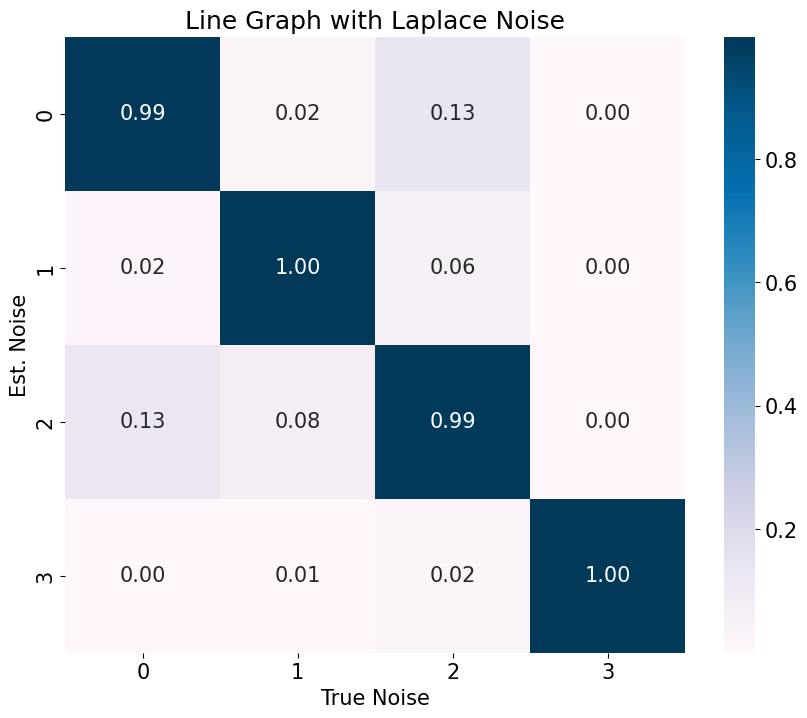

In [105]:
results = []

for i in range(num_latent):
    for j in range(num_latent):
        # Calculate metrics
        pearson_corr = np.abs(np.corrcoef(noises[:, i], noise_estimates[:, j])[0, 1])

        # Append the results as a dictionary to the results list
        results.append({
            'Est. Noise': i,
            'True Noise': j,
            'Pearson Correlation': pearson_corr,
        })

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# # Print the DataFrame using tabulate for a nicer format
# print(tabulate(df_results, headers='keys', tablefmt='pipe', showindex=False))

pivot_df = df_results.pivot(index='Est. Noise', columns='True Noise', values='Pearson Correlation')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap='PuBu', fmt=".2f")
plt.title('Line Graph with Laplace Noise')
plt.show()

In [106]:
DAG_type = 'line'
num_latent = 4
num_samples = 2000
variance_max = 1
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat

In [107]:
layers = [[0], [1], [2,3]]
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
graph = SyntheticDAG(num_latent, DAG_type)
graph.DAG.add_arc(1,3)
graph.DAG.remove_arc(2,3)

Drawing graph...
there are no undirected edges
plotting...


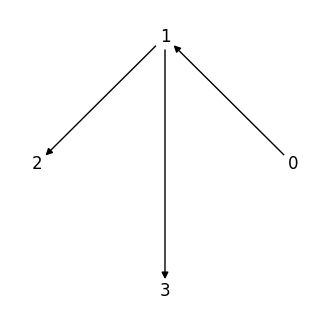

In [108]:
graph.draw_graph()

In [109]:
U,X,noises = graph.sample_scaled(G, num_samples)

In [110]:
id_layers = identify(graph, U, X, G, 0)

-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Optimal solution found:
[ 0.49508081 -0.59376206  0.56160131  0.29486534]

Optimal solution found:
[-0.10101048  0.68122114  0.58276781  0.43141201]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[-8.35522068e-01  4.52123094e-01  8.89276053e-01 -1.22259451e-01]
 [-1.77890737e+00  3.35668198e+00  1.75624418e+00  1.35979970e+00]
 [-6.67245979e-02 -6.91548950e-02 -1.90016413e-03 -1.46638054e-03]
 [ 1.87241969e+00 -2.95119724e+00 -9.42219285e-02 -7.25694022e-02]]

Peeled off 2 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Optimal solution found:
[-0.02899892 -0.9995793 ]

No feasible solution found.
Do

In [111]:
noise_estimates = noise_estimation(id_layers, layers)

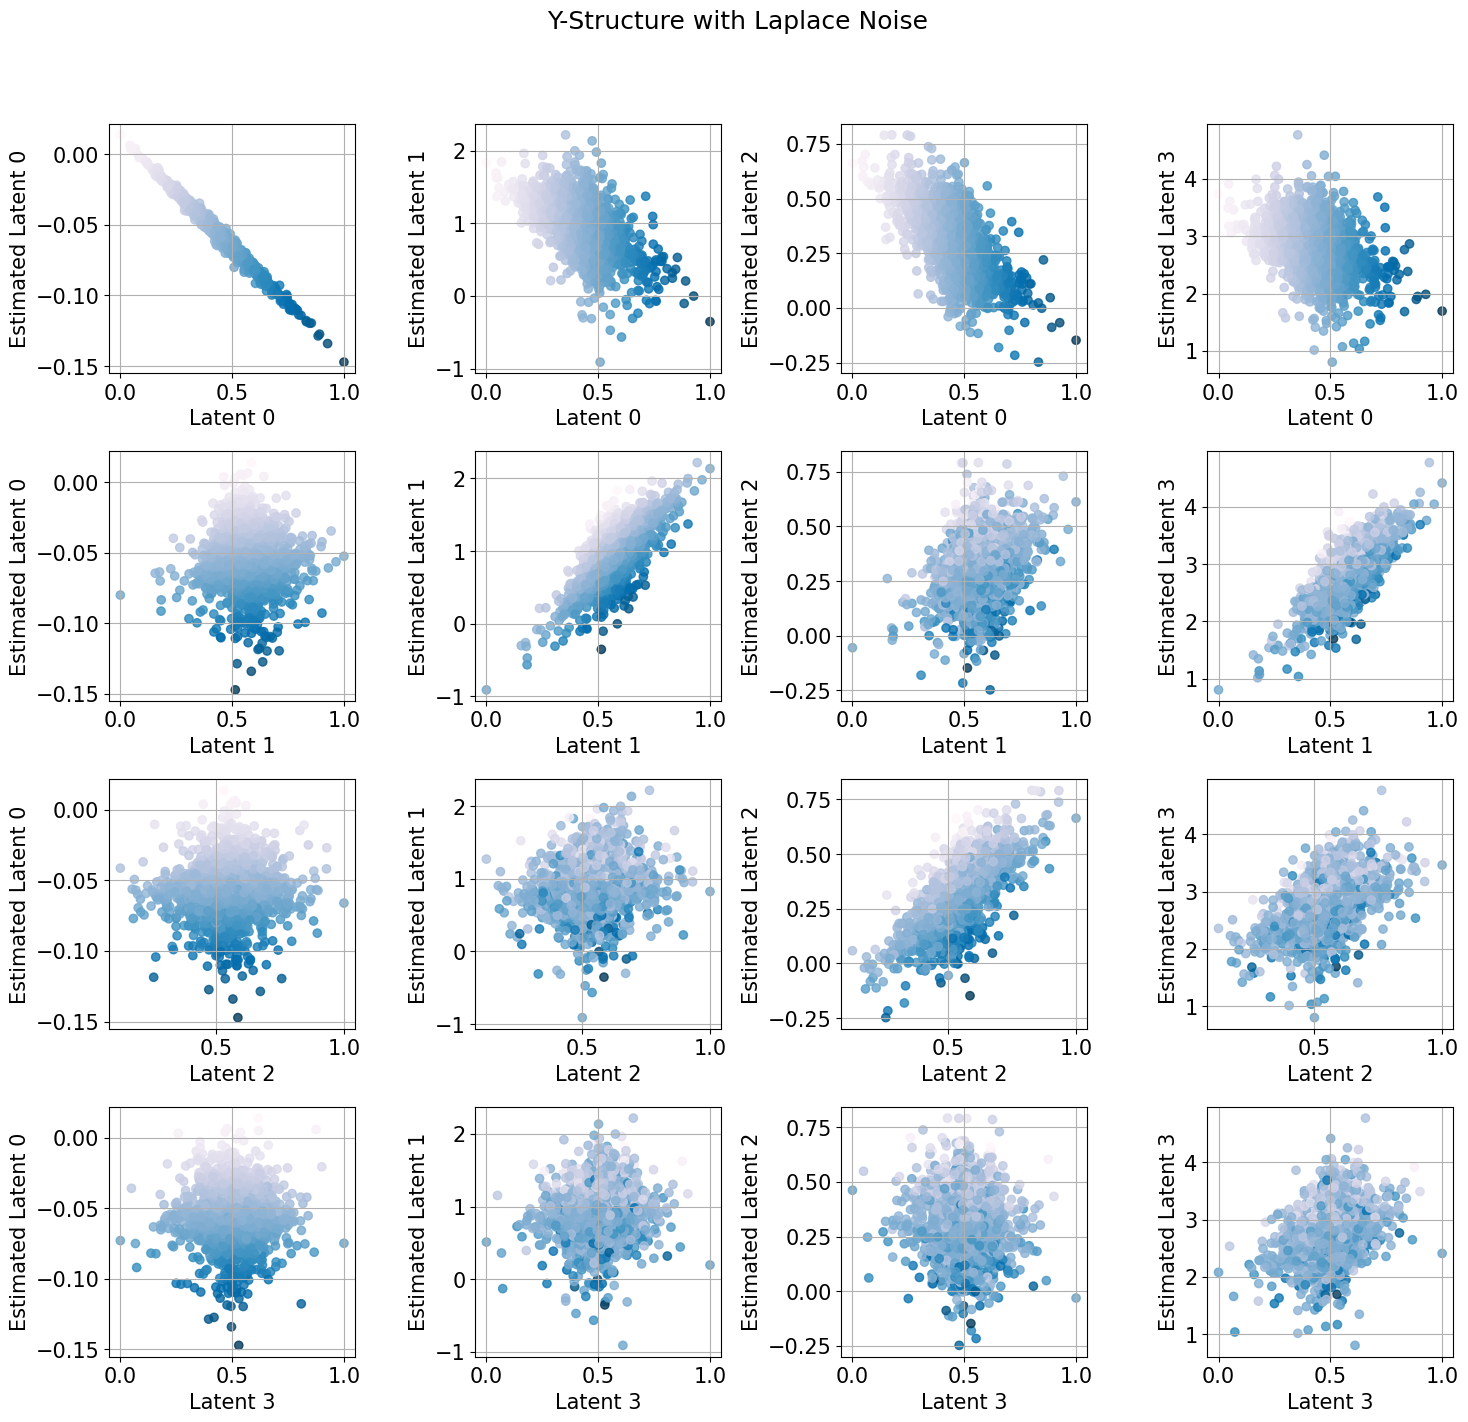

In [112]:
U_np = U.detach().numpy()
fig, axes = plt.subplots(nrows=num_latent, ncols=num_latent, figsize=(15, 15))
# Set a title for the figure
fig.suptitle('Y-Structure with Laplace Noise')

# Iterate over each combination of columns in A and B
for i in range(num_latent):
    for j in range(num_latent):
        ax = axes[i, j]
        ax.scatter(U_np[:, i], id_layers[:, j], alpha=0.8, c = U_np[:,0], cmap='PuBu') # Plotting the scatter plot
        ax.set_xlabel(f'Latent {i}')  # Set x-axis label
        ax.set_ylabel(f'Estimated Latent {j}')  # Set y-axis label
        ax.grid(True)  # Optional: Adds grid to the plots for better visibility

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

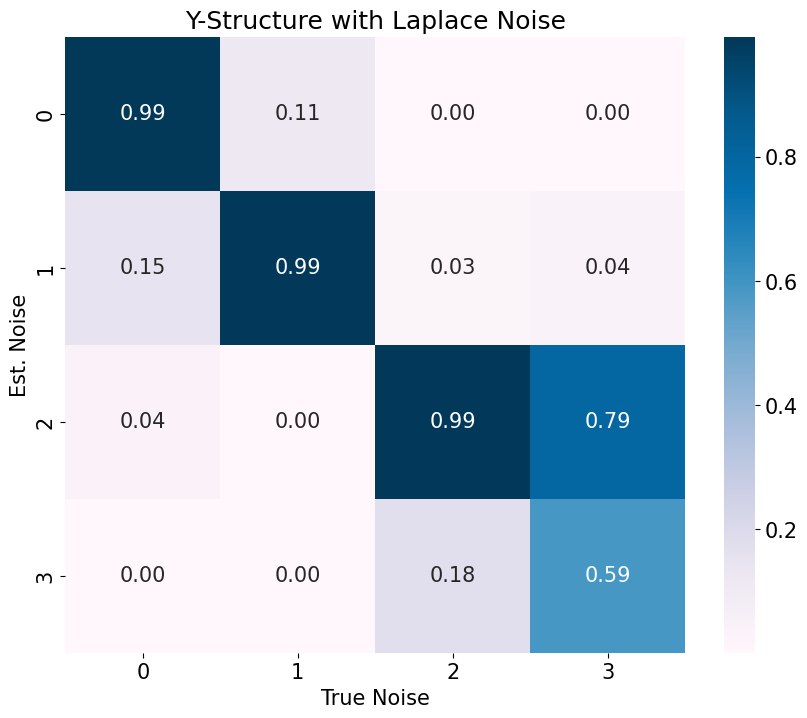

In [113]:
results = []

for i in range(num_latent):
    for j in range(num_latent):
        # Calculate metrics
        pearson_corr = np.abs(np.corrcoef(noises[:, i], noise_estimates[:, j])[0, 1])

        # Append the results as a dictionary to the results list
        results.append({
            'Est. Noise': i,
            'True Noise': j,
            'Pearson Correlation': pearson_corr,
        })

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# # Print the DataFrame using tabulate for a nicer format
# print(tabulate(df_results, headers='keys', tablefmt='pipe', showindex=False))

pivot_df = df_results.pivot(index='Est. Noise', columns='True Noise', values='Pearson Correlation')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap='PuBu', fmt=".2f")
plt.title('Y-Structure with Laplace Noise')
plt.show()